In [1]:
import os 
import sys
import torch
import ast
import trimesh
from tqdm import tqdm
import open3d as o3d
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.spatial.transform import Rotation 

from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, look_at_view_transform,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    HardPhongShader, 
    OpenGLOrthographicCameras,
    PointsRasterizationSettings,
    PointsRasterizer,
    NormWeightedCompositor, DirectionalLights)

notebook_path = os.path.abspath("../")
os.chdir(notebook_path)
from mvtorch.view_selector import MVTN
from mvtorch.mvrenderer import MVRenderer
from mvtorch.utils import torch_color
from mvtorch.data import ScanObjectNN, CustomDataLoader, ModelNet40

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
nb_views = 12
bs = 1
data_dir = "/home/mpelissi/Dataset/ModelNet40/"
category = "all"
views_config = "circular"

# Global parameters
points_per_pixel=1; points_radius=0.02; image_size=224

In [12]:
# Model 3D remeshing iso
dir_remeshing =  "/home/mpelissi/Dataset/ModelNet40_remeshing_iso"
dir_output = "/home/mpelissi/MVTN/my_MVTN/outputs"
all_mesh_iso = glob.glob(os.path.join(dir_remeshing, "*/*/*.obj")); print(f"🔎​​​ Number of meshes found in {dir_remeshing} : {len(all_mesh_iso)}"
                                                                          )

# Number of samples to load per class (for faster experimentation)
samples_per_class_train = None  # Adjust this number as needed
samples_per_class_test = None # Adjust this number as needed
## Data loading
dset_train = ModelNet40(data_dir=data_dir, split='train', samples_per_class=samples_per_class_train, category=category)
dset_test = ModelNet40(data_dir=data_dir, split='test', samples_per_class=samples_per_class_test, category=category)
train_loader = CustomDataLoader(dset_train, batch_size=bs, shuffle=True, drop_last=False, pin_memory=True)
test_loader = CustomDataLoader(dset_test, batch_size=bs, shuffle=False, drop_last=False, pin_memory=True)
print(f"🔎​​​ Which categories are used ? 🚨​ {category} 🚨​\n")

🔎​​​ Number of meshes found in /home/mpelissi/Dataset/ModelNet40_remeshing_iso : 12311
🔎​​​ Which categories are used ? 🚨​ all 🚨​



In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu');  print("💻 device : ", device)
mvtn = MVTN(nb_views, views_config).cuda()
mvrenderer = MVRenderer(nb_views=nb_views, return_mapping=False, pc_rendering=False).cuda()

💻 device :  cuda


Reference

In [7]:
for i, (targets, meshes, points, names) in enumerate(train_loader):   
    # reference mesh   
    azim, elev, dist = mvtn(points, c_batch_size=len(targets))
    print("Azimuth:", azim, "\nElevation:", elev, "\nDistance:", dist)
    rendered_images, _ = mvrenderer(meshes, points, azim=azim, elev=elev, dist=dist)
    break

Azimuth: tensor([[-270., -240., -210., -180., -150., -120.,  -90.,  -60.,  -30.,    0.,
           30.,   60.]], device='cuda:0') 
Elevation: tensor([[30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.]],
       device='cuda:0') 
Distance: tensor([[1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000,
         1.1000, 1.1000, 1.1000]], device='cuda:0')


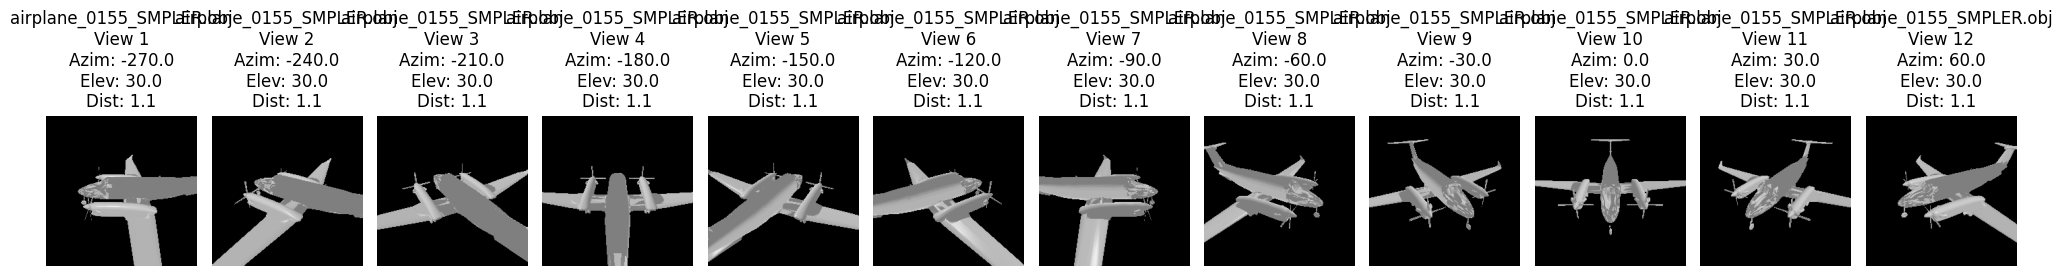

In [8]:
# Create a figure with subplots for each view
fig, axes = plt.subplots(bs, nb_views, figsize=(20, 8))

# Iterate through the batch (2 objects)
for i in range(bs):
    # Iterate through 6 of the 12 views for each object
    for j in range(nb_views):
        ax = axes[j]
        # Get image from rendered_images and move to CPU, take first 3 channels
        img = rendered_images[i, j].cpu().detach().permute(1, 2, 0)[:, :, :3]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'{os.path.basename(names[i])}\nView {j+1}\nAzim: {azim[i,j]:.1f}\nElev: {elev[i,j]:.1f}\nDist: {dist[i,j]:.1f}')

plt.tight_layout()

# Pour 1 obj


In [18]:
path_mesh_modelnet40 = names[0]; print(f"🔎​​​ Path to the reference mesh : {path_mesh_modelnet40}")
path_mesh_iso = [p for p in all_mesh_iso if os.path.basename(path_mesh_modelnet40).split('_SM')[0] in p][0]
cat = path_mesh_iso.split('/')[-3]; type = path_mesh_iso.split('/')[-2]; name = path_mesh_iso.split('/')[-1].split('.')[0]
print(cat, type, name)

🔎​​​ Path to the reference mesh : /home/mpelissi/Dataset/ModelNet40//airplane/train/airplane_0155_SMPLER.obj
airplane train airplane_0155_SMPLER_centered_scaled_remeshing_iso_iter7


Alignement OBJ et PLY

Projections dans les N vues

In [ ]:
# Depthmaps
rendered_images, cameras, new_meshes, meshes, R, T = my_render_meshes(mesh_init, None, azims, elevs, dists, light)
# transform xyz to the camera view coordinates
cam_points = cameras.get_world_to_view_transform().transform_points(world_points)
cam_points_np = cam_points.cpu().numpy()
# transform xyz to the camera view coordinates
cam_normals = cameras.get_world_to_view_transform().transform_normals(world_normals)
cam_normals_np = cam_normals.cpu().numpy()
# Cartes de profondeur
depthmaps_np = fragments.zbuf[:,:,:,0].cpu().numpy()

In [ ]:
# Assuming depthmap_i is generated for each view in the loop from cell 13
fig, axes = plt.subplots(views//6, 6, figsize=(20, 6))
fig.suptitle("My Depth Images "+name, fontsize=16)

for i in range(views):
    row, col = divmod(i, 6)    
    axes[row, col].imshow(depthmaps_np[i], cmap='viridis')
    axes[row, col].set_title(f"View {i+1} {c_views_azim[0,i]} {c_views_elev[0,i]} {c_views_dist[0,i]}")
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=axes[row, col], orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Depth Value')

plt.tight_layout()
plt.show()

In [ ]:
# pix_to_face is of shape (N, H, W, 1)
pix_to_face = fragments.pix_to_face ; print("pix_to_face shape:", pix_to_face.shape)  # Expected: [N, H, W, 1]
pix_to_face = fragments.pix_to_face[..., 0] ; print("pix_to_face shape:", pix_to_face.shape)  # Expected: [N, H, W]
print("pix_to_face shape:", pix_to_face.shape)  # Expected: [N, H, W]

In [ ]:
visible_faces_per_view = []
visible_verts_per_view = []
#faces = world_mesh.faces_packed()  # (F, 3)

for b in tqdm(range(pix_to_face.shape[0])):
    array_pt_cloud_b = cam_points_np[b]
    array_normals_b = cam_normals_np[b]
    
    # 1. Get valid face indices (ignore -1 = background)
    face_ids = pix_to_face[b]
    idx_visible_faces_b = torch.unique(face_ids[face_ids >= 0]) % nb_faces  # remove -1 (background)
    idx_visible_faces_b_np = idx_visible_faces_b.cpu().numpy()
    visible_faces_per_view.append(idx_visible_faces_b)
    print(f"Visible faces for view {b}: {idx_visible_faces_b.shape}")  
    
    # 2. Extract visible vertices from those faces
    idx_visible_verts_b = torch.unique(torch.tensor(array_faces)[idx_visible_faces_b])
    idx_visible_verts_b_np = idx_visible_verts_b.cpu().numpy()
    visible_verts_per_view.append(idx_visible_verts_b)   
    print(f"Visible vertices for view {b}: {idx_visible_verts_b.shape}") 
    
    obj_filename = f"{os.path.join(dir_output, name)}_myview_{b+1}_color.obj"
    write_obj_with_color(array_pt_cloud_b, array_faces, idx_visible_verts_b_np, obj_filename)
    
    ## Angle sommets visibles
    cos_angle_visible_vertex_b = np.full(array_pt_cloud_b.shape[0], np.nan)
    # sommets et normales visibles
    v_visible = array_pt_cloud_b[idx_visible_verts_b_np]
    n_visible = array_normals_b[idx_visible_verts_b_np]
    n_norms = np.linalg.norm(n_visible, axis=1, keepdims=True)
    n_norms[np.where(n_norms == 0)] = 1e-10 # quelques normales sont nulles
    # normalisation
    n_visible_norm = n_visible / n_norms
    # vecteurs directeurs
    D = -v_visible
    D /= np.linalg.norm(D, axis=1, keepdims=True)
    cos_alpha = np.abs(np.sum(D * n_visible_norm, axis=1))
    cos_angle_visible_vertex_b[idx_visible_verts_b_np] = cos_alpha   
    obj_filename_angle = f"{os.path.join(dir_output, name)}_myview_{b+1}_angles.obj"
    save_colored_obj_with_faces(obj_filename_angle, array_pt_cloud_b, cos_angle_visible_vertex_b, array_faces)
    
    
    # Surface Totale 3D
    surface3D_b = np.sum(calculer_aires_triangles_batch(array_pt_cloud_b, array_faces))
    # Surface visible de la projection courante
    surface3D_visible_b = np.sum(calculer_aires_triangles_batch(array_pt_cloud_b, array_faces[idx_visible_faces_b_np]))
    
    #data_output_path = os.path.join(dir_output, cat, type, name+"_cam"+str(i+1)+"_data.npz")
    data_output_path = os.path.join(dir_output, name+"_cam"+str(b+1)+"_data.npz")

    # Step 1: Save all array data in a compressed .npz file
    # np.savez_compressed(
    #     data_output_path,
    #     array_pt_cloud = array_pt_cloud_b,
    #     array_normals = array_normal_b,
    #     dephtmap = depthmaps_np[b],
    #     visible_vertex_idx = idx_visible_verts_b_np,
    #     visible_faces = idx_visible_faces_b_np,
    #     cos_angles = cos_angle_visible_vertex_b,
    #     surface3D = surface3D_b,
    #     surface3D_visible = surface3D_visible_b)

In [ ]:
np.max(idx_visible_faces_b_np)